# Import required modules

In [ ]:
import pandas as pd
from collections import Counter
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import arff
import os
import io
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Load data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/TextCollection_sms.csv', sep="|", error_bad_lines=False, encoding='latin-1') #for this i saved the file on my google drive #added: encoding='latin-1')
data['Message']=data['Message'].astype(str)
data = data.dropna()
data

Mounted at /content/drive


<ipython-input-2-39a5130f69d7>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('/content/drive/My Drive/TextCollection_sms.csv', sep="|", error_bad_lines=False, encoding='latin-1') #for this i saved the file on my google drive #added: encoding='latin-1')
Skipping line 194: expected 3 fields, saw 4
Skipping line 510: expected 3 fields, saw 4
Skipping line 1721: expected 3 fields, saw 4
Skipping line 1848: expected 3 fields, saw 10
Skipping line 2160: expected 3 fields, saw 7
Skipping line 2599: expected 3 fields, saw 9
Skipping line 2792: expected 3 fields, saw 4
Skipping line 2851: expected 3 fields, saw 7
Skipping line 3213: expected 3 fields, saw 4
Skipping line 3326: expected 3 fields, saw 4
Skipping line 3452: expected 3 fields, saw 7
Skipping line 3568: expected 3 fields, saw 4
Skipping line 4470: expected 3 fields, saw 4
Skipping line 4827: expected 3 fields, saw 9
S

,id,Message,Class
0,1,"Go until jurong point,crazy.. Available only i...",0.0
1,2,Ok lar... Joking wif u oni...,0.0
2,3,Free entry in 2 a wkly comp to win FA Cup fina...,1.0
3,4,U dun say so early hor... U c already then say...,0.0
4,5,"Nah I don\''t think he goes to usf,he lives ar...",0.0
...,...,...,...
5554,5571,Will ÃÂ¼ b going to esplanade fr home?,0.0
5555,5572,"Pity,* was in mood for that. So...any other su...",0.0
5556,5573,The guy did some bitching but I acted like i\'...,0.0
5557,5574,Rofl. Its true to its name,0.0


Get to know data set, is the class attribute (class-attr)
values balanced? How many spam messages does
the data set contain?

- Non-Spam: 4772
- Spam: 741

In [ ]:
df = data.groupby(['Class'], sort=False).size().reset_index(name='Count')
df

,Class,Count
0,0.0,4772
1,1.0,741


# Cleanup Data

Convert messages to lowercase

In [ ]:
data['Message'] = data['Message'].str.lower()
data

,id,Message,Class
0,1,"go until jurong point,crazy.. available only i...",0.0
1,2,ok lar... joking wif u oni...,0.0
2,3,free entry in 2 a wkly comp to win fa cup fina...,1.0
3,4,u dun say so early hor... u c already then say...,0.0
4,5,"nah i don\''t think he goes to usf,he lives ar...",0.0
...,...,...,...
5554,5571,will ãâ¼ b going to esplanade fr home?,0.0
5555,5572,"pity,* was in mood for that. so...any other su...",0.0
5556,5573,the guy did some bitching but i acted like i\'...,0.0
5557,5574,rofl. its true to its name,0.0


Remove punctuation and stopwords from the messages

In [ ]:
nltk.download('stopwords')

def prepare_message(text):
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

data['Message'] = data['Message'].apply(prepare_message)
data.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,Message,Class
0,1,go jurong point crazy available bugis n great ...,0.0
1,2,ok lar joking wif u oni,0.0
2,3,free entry 2 wkly comp win fa cup final tkts 2...,1.0
3,4,u dun say early hor u c already say,0.0
4,5,nah think goes usf lives around though,0.0


Create data frames processed data and target

In [ ]:
msg = pd.DataFrame(data['Message'])
target = pd.DataFrame(data['Class'])


# Convert words to vectors

In [ ]:
from collections import Counter

total_frequency_counts = Counter()
for i in range(len(msg)):
    for word in msg.values[i][0].split(" "):
        total_frequency_counts[word] += 1

presence_words = []
for i in range(len(msg)):
  presence_words.extend(list(set(msg.values[i][0].split(" "))))
total_presence_counts = Counter(presence_words)

print("Total frequency words in data set: ", len(total_frequency_counts))
print("Total presence words in data set: ", len(total_presence_counts))

Total frequency words in data set:  8633
Total presence words in data set:  8633


In [ ]:
vocab_frequency = sorted(total_frequency_counts, key=total_frequency_counts.get, reverse=True)
vocab_frequency_100 = vocab_frequency[:100]
vocab_frequency_1000 = vocab_frequency[:1000]
print("Frequency vocabolary: ", vocab_frequency[:10])

presence_vocab = sorted(total_presence_counts, key=total_presence_counts.get, reverse=True)
presence_vocab_100 = presence_vocab[:100]
presence_vocab_1000 = presence_vocab[:1000]
print(presence_vocab[:10])
print("Presence vocabolary: ", presence_vocab[:10])

Frequency vocabolary:  ['u', 'call', '2', 'ur', 'get', '4', 'gt', 'lt', 'ok', 'free']
['u', 'call', '2', 'get', 'ur', '4', 'ok', 'go', 'know', 'lt']
Presence vocabolary:  ['u', 'call', '2', 'get', 'ur', '4', 'ok', 'go', 'know', 'lt']


In [ ]:
word_map_frequency_100 = {}
for i, word in enumerate(vocab_frequency_100):
    word_map_frequency_100[word] = i

word_map_frequency_1000 = {}
for i, word in enumerate(vocab_frequency_1000):
    word_map_frequency_1000[word] = i

word_map_presence_100 = {}
for i, word in enumerate(presence_vocab_100):
    word_map_presence_100[word] = i

word_map_presence_1000 = {}
for i, word in enumerate(presence_vocab_1000):
    word_map_presence_1000[word] = i


In [ ]:
def text_to_vector(text, vocab_size, word_map):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word_map.get(word) is None:
            continue
        else:
            word_vector[word_map.get(word)] += 1
    return np.array(word_vector)

word_vectors_frequency_100 = np.zeros((len(msg), len(vocab_frequency_100)), dtype=np.int_)
for i, (_, t) in enumerate(msg.iterrows()):
    word_vectors_frequency_100[i] = text_to_vector(t[0], len(vocab_frequency_100), word_map_frequency_100)

word_vectors_frequency_1000 = np.zeros((len(msg), len(vocab_frequency_1000)), dtype=np.int_)
for i, (_, t) in enumerate(msg.iterrows()):
    word_vectors_frequency_1000[i] = text_to_vector(t[0], len(vocab_frequency_1000), word_map_frequency_1000)

word_vectors_presence_100 = np.zeros((len(msg), len(presence_vocab_100)), dtype=np.int_)
for i, (_, t) in enumerate(msg.iterrows()):
    word_vectors_presence_100[i] = text_to_vector(t[0], len(presence_vocab_100), word_map_presence_100)

word_vectors_presence_1000 = np.zeros((len(msg), len(presence_vocab_1000)), dtype=np.int_)
for i, (_, t) in enumerate(msg.iterrows()):
    word_vectors_presence_1000[i] = text_to_vector(t[0], len(presence_vocab_1000), word_map_presence_1000)

# word_vectors.shape

# Classify word **frequency 100**

In [ ]:
features = word_vectors_frequency_100
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=42)

clfs = {'SVC' : svc,'KNC' : knc, 'MNB': mnb, 'DTC': dtc, 'LRC': lrc, 'RFC': rfc}

pred_scores_word_vectors = []
for k,v in clfs.items():
    v.fit(x_train, y_train)
    pred = v.predict(x_test)

    a = accuracy_score(y_test, pred);
    f1 = f1_score(y_true = y_test, y_pred = pred, average='weighted');
    pred_scores_word_vectors.append((k, a, f1))

pred_scores_word_vectors

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

[('SVC', 0.8972188633615478, 0.8993130120849215),
 ('KNC', 0.905683192261185, 0.8894341992467183),
 ('MNB', 0.9540507859733979, 0.9526800047268661),
 ('DTC', 0.9649334945586457, 0.9638060468484893),
 ('LRC', 0.9625151148730351, 0.9614827798156772),
 ('RFC', 0.9685610640870617, 0.967476485665196)]

Confusion matrix for Support vector machines

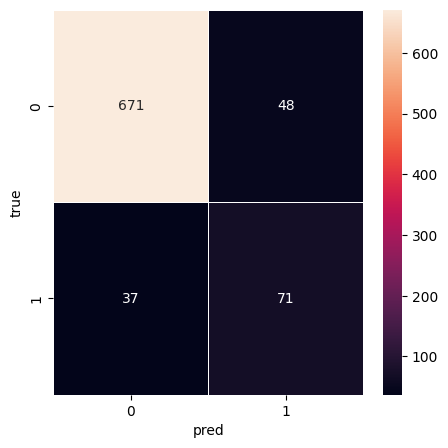

In [ ]:
y_pred_nb = svc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for KNN

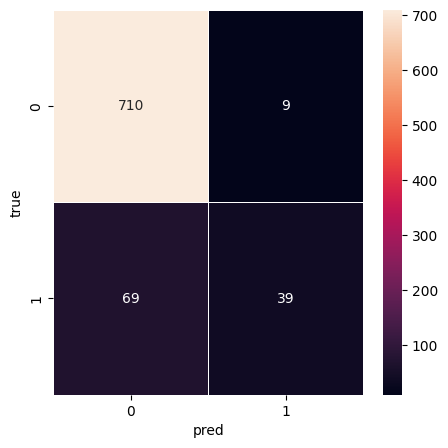

In [ ]:
y_pred_nb = knc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Decision Tree

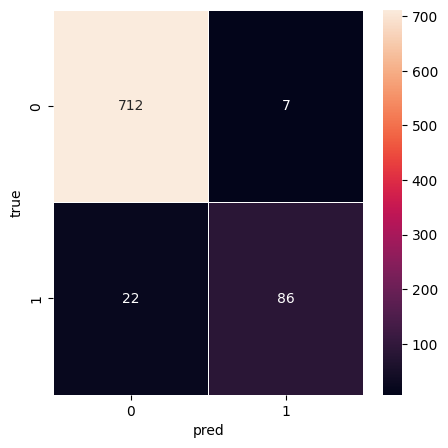

In [ ]:
y_pred_nb = dtc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion Matrix for Logistic Regression

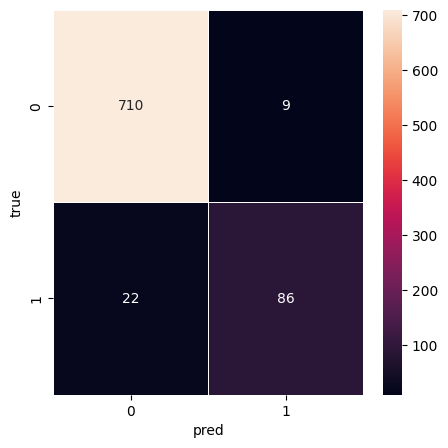

In [ ]:
y_pred_nb = lrc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Naive Bayes

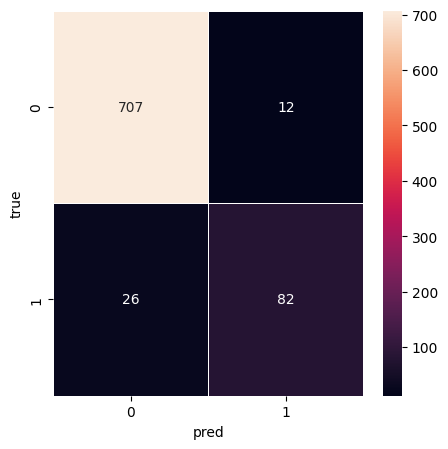

In [ ]:
y_pred_nb = mnb.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()


Confusion Matrix for RandomForrest

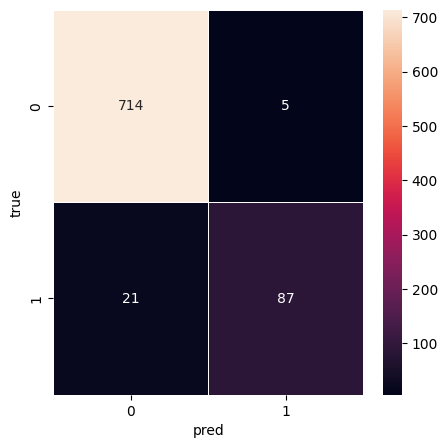

In [ ]:
y_pred_nb = rfc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

**Summary word frequency 100**: Classifying word frequency 100 has been executed the best by Random Forest Classifier with the Accuracy of 0.9686 and weighted F-measure of 0.9675
In the second place is Decision Tree with the accuracy of 0.9649 and weighted F-measure of 0.9638.

The worst performing classifier has been the support vector machine with the accuracy of 0.8972 and weighted F-measure of 0.8993 followed by KNN with the accuracy of 0.9057 and weighted F-measure of 0.8894.

Thus we can conlude that the Random Forest performs better due to its nature of combination of multiple trees and reduced overfitting and as for the SVC it doesn't perform well, because
it is been trained on the imbalanced dataset leading it to being biased towards the majority class.  

#Classify word **frequency 1000**

In [ ]:
features = word_vectors_frequency_1000
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=42)

clfs = {'SVC' : svc,'KNC' : knc, 'MNB': mnb, 'DTC': dtc, 'LRC': lrc, 'RFC': rfc}

pred_scores_word_vectors = []
for k,v in clfs.items():
    v.fit(x_train, y_train)
    pred = v.predict(x_test)

    a = accuracy_score(y_test, pred);
    f1 = f1_score(y_true = y_test, y_pred = pred, average='weighted');
    pred_scores_word_vectors.append((k, a, f1))

pred_scores_word_vectors

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

[('SVC', 0.9141475211608222, 0.9152849999866052),
 ('KNC', 0.8694074969770254, 0.8086726912373625),
 ('MNB', 0.9794437726723095, 0.9792358291759428),
 ('DTC', 0.973397823458283, 0.9729598314570242),
 ('LRC', 0.9782345828295043, 0.9777814528322238),
 ('RFC', 0.9794437726723095, 0.9786858307877998)]

Confusion matrix for Support vector machines

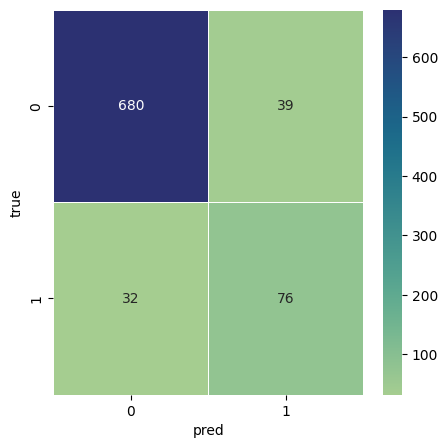

In [ ]:
y_pred_nb = svc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True, cmap='crest', linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for KNN

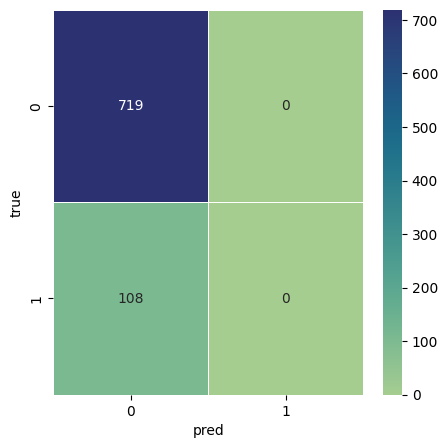

In [ ]:
y_pred_nb = knc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,cmap='crest',linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Decision Tree

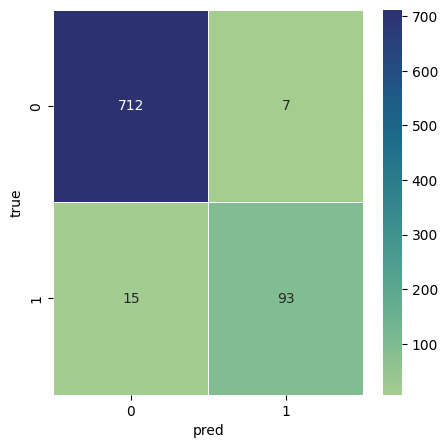

In [ ]:
y_pred_nb = dtc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,cmap='crest',linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion Matrix for Logistic Regression

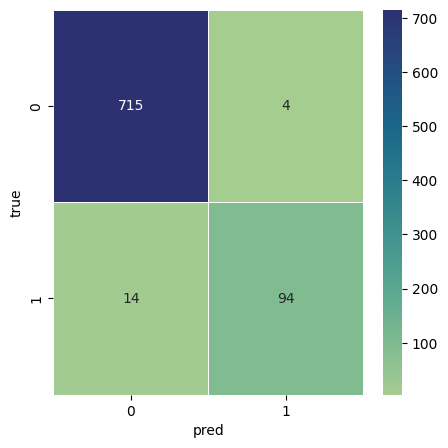

In [ ]:
y_pred_nb = lrc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,cmap='crest',linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Naive Bayes

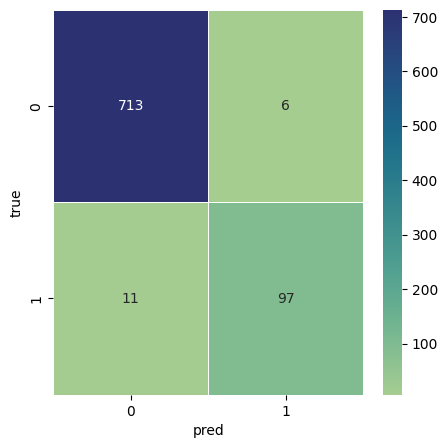

In [ ]:
y_pred_nb = mnb.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,cmap='crest',linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()


Confusion Matrix for RandomForrest

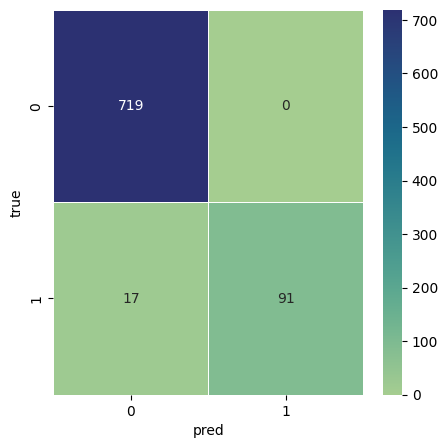

In [ ]:
y_pred_nb = rfc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,cmap='crest',linewidths=0.5,linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Summary word frequency 1000: Classifying word frequency 1000 has been executed the best by Naive Bayes Classifier with the Accuracy of 0.9794 and weighted F-measure of 0.9792. Random Forest shares the same Accuracy and weighted F-measure less for 0.0006.

The worst performing classifier has been KNN with the accuracy of 0.8694 and weighted F-measure of 0.8087.



#Classify word presence 100

In [ ]:
features = word_vectors_presence_100
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=42)

clfs = {'SVC' : svc,'KNC' : knc, 'MNB': mnb, 'DTC': dtc, 'LRC': lrc, 'RFC': rfc}

pred_scores_word_vectors = []
for k,v in clfs.items():
    v.fit(x_train, y_train)
    pred = v.predict(x_test)

    a = accuracy_score(y_test, pred);
    f1 = f1_score(y_true = y_test, y_pred = pred, average='weighted');
    pred_scores_word_vectors.append((k, a, f1))

pred_scores_word_vectors

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

[('SVC', 0.9008464328899637, 0.9019786220055755),
 ('KNC', 0.9081015719467956, 0.893015592434677),
 ('MNB', 0.9552599758162031, 0.9536103375969756),
 ('DTC', 0.9613059250302297, 0.9597862838491618),
 ('LRC', 0.9637243047158404, 0.9626421089948942),
 ('RFC', 0.9625151148730351, 0.9607664658320514)]

Confusion matrix for Support vector machines

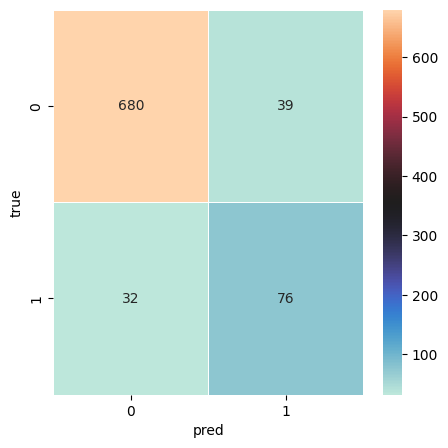

In [ ]:
y_pred_nb = svc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap='icefire',linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for KNN

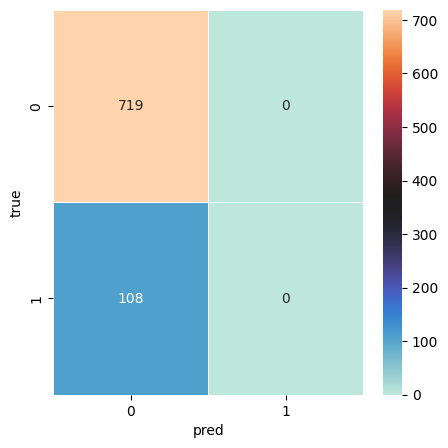

In [ ]:
y_pred_nb = knc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap='icefire',linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Decision Tree

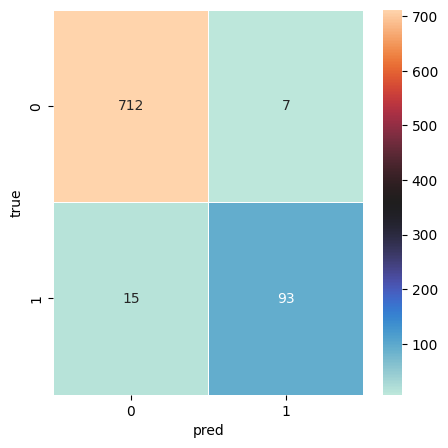

In [ ]:
y_pred_nb = dtc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap='icefire',linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Logistic Regression

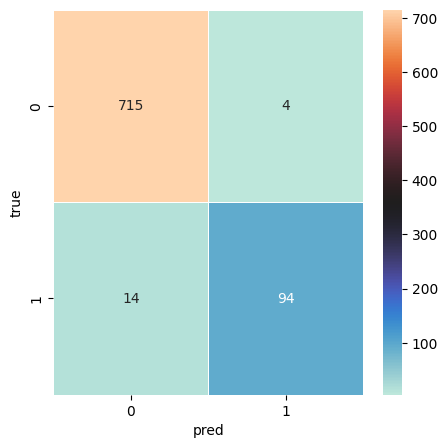

In [ ]:
y_pred_nb = lrc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap='icefire',linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Naive Bayes

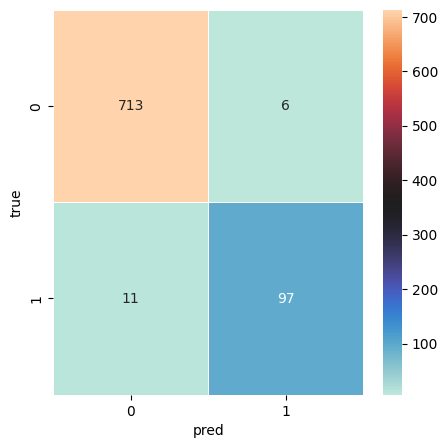

In [ ]:
y_pred_nb = mnb.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap='icefire',linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()


Confusion matrix for Random Forrest

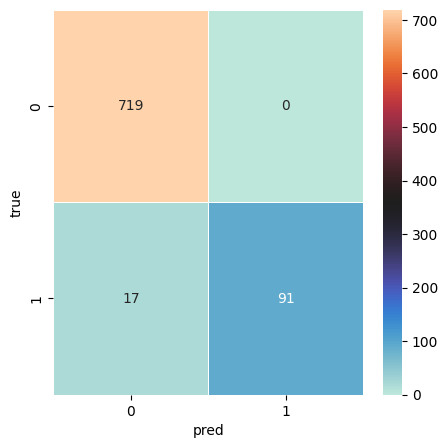

In [ ]:
y_pred_nb = rfc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap='icefire',linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Summary of classifying word presence 100: The best performing classifier has been Naive Bayes again with the accuracy of 0.9553 and weighted F-measure of 0.9536 due to the reason that the presence of certain words is strongly linked to their respective categories, and thus the mutual independence assumption is stronger leading to better prediction results.

The worst performing has been Support Vector Machines with accuracy of 0.9008 and weighted F-measure 0.9020 and KNN with weighted F-measure worse of respectively 0.8930.

#Classify word presence 1000

In [ ]:
features = word_vectors_presence_1000
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=42)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=42)

clfs = {'SVC' : svc,'KNC' : knc, 'MNB': mnb, 'DTC': dtc, 'LRC': lrc, 'RFC': rfc}

pred_scores_word_vectors = []
for k,v in clfs.items():
    v.fit(x_train, y_train)
    pred = v.predict(x_test)

    a = accuracy_score(y_test, pred);
    f1 = f1_score(y_true = y_test, y_pred = pred, average='weighted');
    pred_scores_word_vectors.append((k, a, f1))

pred_scores_word_vectors

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

[('SVC', 0.9129383313180169, 0.9142494748298859),
 ('KNC', 0.8694074969770254, 0.8086726912373625),
 ('MNB', 0.9794437726723095, 0.9792358291759428),
 ('DTC', 0.9794437726723095, 0.9790608256171377),
 ('LRC', 0.9782345828295043, 0.9777814528322238),
 ('RFC', 0.9818621523579202, 0.9812789897492186)]

Confusion matrix for Support vector machines

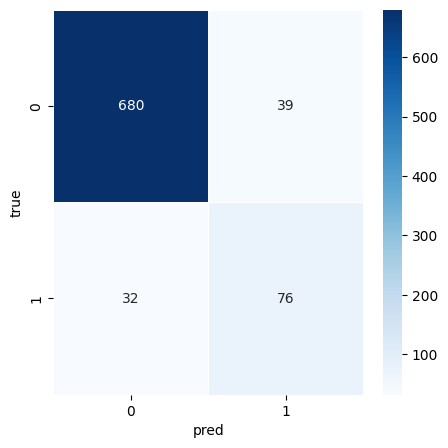

In [ ]:
y_pred_nb = svc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap="Blues",linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for KNN

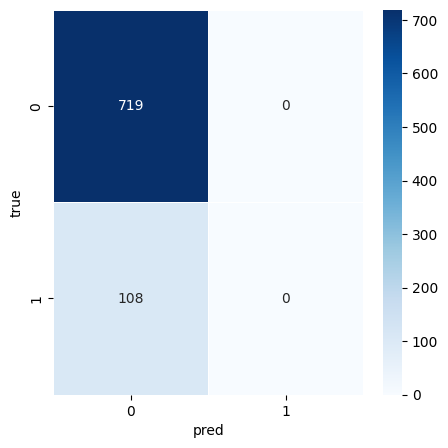

In [ ]:
y_pred_nb = knc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap="Blues",linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Decision Tree

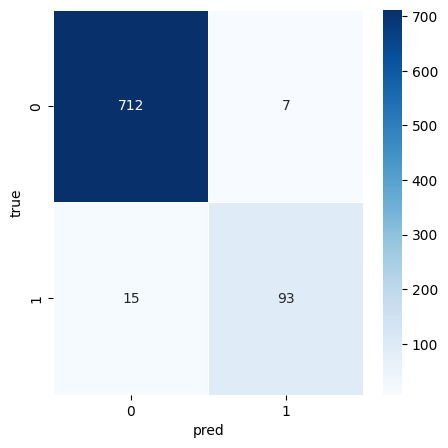

In [ ]:
y_pred_nb = dtc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap="Blues",linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Logistic Regression

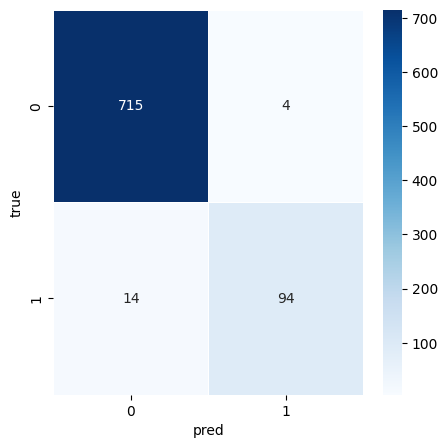

In [ ]:
y_pred_nb = lrc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap="Blues",linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Naive Bayes

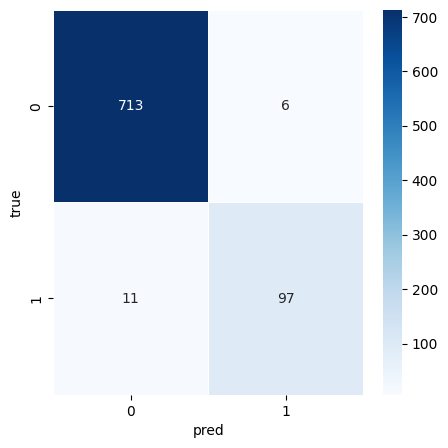

In [ ]:
y_pred_nb = mnb.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap="Blues",linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Confusion matrix for Random Forrest

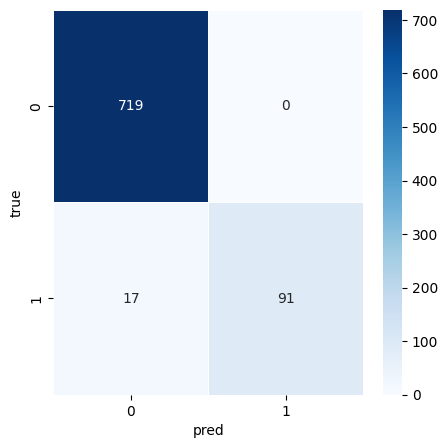

In [ ]:
y_pred_nb = rfc.predict(x_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,cmap="Blues",linecolor="white",fmt = ".0f",ax=ax)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

Summary abuot the **word presence 1000**: The with increasing number of words the best performing classifiers are Naive Bayes and Random Decision Tree with Accuracy of 0.9794 and weighted F-measure of 0.9792 and 0.9790 respectively showing that they deliver practically the same results. According to confusion matrix, however we can see, that the class 0 and 1 was recognised correctly more times by Naive Bays.

The worst performance has been by KNN with accuracy of 0.8694 and weighted F-measure of 0.8087. Logistic Regression has managed to produce better results with the accuracy of 0.9782 and weighted F-measure of 0.9778.

# Conclusions

After adjusting different parameters overall i can distuingish **Naive Bayes** with the highet **F-measure of 0.9792** for **both word frequency 1000** and **word presence 1000**. However, Random Forest seems to have very close results with instances where F-measure differes as little as 0.0002.

Naive Bayes is known to work best with text-based datasets even if the dataset is relatively small. The presence of certain words is strongly linked to their respective categories, and thus the mutual independence assumption is stronger. The positive aspect of this independance is that the words in the text messages are separated and treated as 1d distributions, there is no overfitting. In the case of Random Forest, there is a strong tendency of overfitting, including possibly unneeded words.